In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [184]:
def compute_box_kernel_weights(X, h):
    '''
        X is the difference in the x-coordinate between the estimated point and a given data point
        h is the bandwidth
    '''
    weights = np.zeros((len(X),))
    weights[abs(X)<h] = 1
    return weights

def compute_box_kernel_estimate(X, Y, h):
    w = compute_box_kernel_weights(X, h)
    pos_idx = np.where(w>0)
    pos_weights = w[pos_idx]
    if len(pos_weights) == 0:
        estimate = np.nan
    else:
        estimate = np.sum(Y[pos_idx]) / np.sum(pos_weights)
    return estimate

def compute_epanechnikov_weights(X, h):
    '''
        X is the difference in the x-coordinate between the estimated point and a given data point
        h is the bandwidth
    '''
    w = 3/(4*h) * (1-np.square(np.divide(X,h)))
    return w

def compute_epanechnikov_estimate(X, Y, h):
    w = compute_epanechnikov_weights(X, h)
    pos_idx = np.where(w>0)
    pos_weights = w[pos_idx]
    if len(pos_weights) == 0:
        estimate = np.nan
    else:
        estimate = np.dot(pos_weights, Y[pos_idx]) / np.sum(pos_weights)
    return estimate


In [185]:
df = pd.read_csv("fev.txt", sep="\t").sort_values("height")
df = df[["fev", "height"]]
Y = df["fev"].to_numpy()
X = df["height"].to_numpy()
N = len(Y)

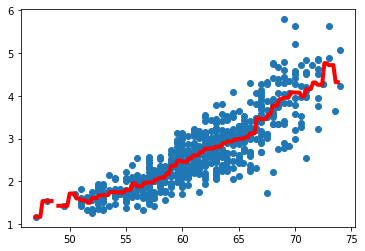

In [186]:
box_kernel_curve = []
bandwidth = 0.5
for x0 in np.arange(min(X), max(X), 0.2):
    estimate = compute_box_kernel_estimate(X-x0, Y, h=bandwidth)
    box_kernel_curve.append((x0, estimate))
box_kernel_curve = np.array(box_kernel_curve)
fig, ax = plt.subplots()
ax.scatter(X, Y)
ax.plot(box_kernel_curve[:,0], box_kernel_curve[:,1], "red", lw=4)

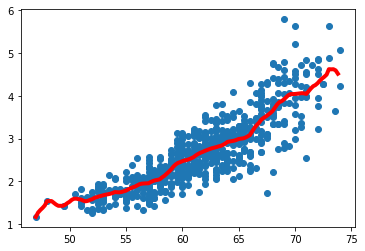

In [187]:
epa_kernel_curve = []
bandwidth = 1
for x0 in np.arange(min(X), max(X), 0.2):
    estimate = compute_epanechnikov_estimate(X-x0, Y, h=bandwidth)
    epa_kernel_curve.append((x0, estimate))
epa_kernel_curve = np.array(epa_kernel_curve)
fig, ax = plt.subplots()
ax.scatter(X, Y)
ax.plot(epa_kernel_curve[:,0], epa_kernel_curve[:,1], "red", lw=4)

In [213]:
def LOOCV(X, Y, h, kernel="epanechnikov"):
    fig, ax = plt.subplots()
    N = len(X)
    SE = np.empty((N,))
    SE[:] = np.nan
    est = np.zeros((N,))
    for i in range(N):
        X_est = X[i]
        Y_true = Y[i]
        X_train = np.delete(X,i)
        Y_train = np.delete(Y,i)
        if kernel == "epanechnikov":
            estimate = compute_epanechnikov_estimate(X_train-X_est, Y_train, h)
        elif kernel == "box":
            estimate = compute_box_kernel_estimate(X_train-X_est, Y_train, h)
        else:
            raise Exception(f"Invalid kernel value: {kernel}")
            
        if not np.isnan(estimate):
            SE[i] = (Y_true - estimate) ** 2
        est[i] = estimate
    SE_valid = SE[~np.isnan(SE)]
    MSE = np.mean(SE_valid)
    ax.scatter(X, Y, s=0.5, c="blue")
    ax.scatter(X, est, s=1, c="red")
    ax.set_title(f"LOOCV {kernel} kernel, bandwidth {h:.2f}")
    return MSE

def find_bandwidth_LOOCV(kernel):
    bw_array = np.arange(0.5, 8, 0.2)
    MSE_LOOCV = np.zeros((len(bw_array), 2)) 

    for i, bw in enumerate(bw_array):
        MSE_LOOCV[i] = [bw, LOOCV(X, Y, bw, kernel=kernel)]
    fig, ax = plt.subplots()
    ax.scatter(MSE_LOOCV[:,0], MSE_LOOCV[:,1])
    ax.set_title("MSE vs kernel width (LOOCV)")
    ax.set_xlabel("kernel width")
    ax.set_ylabel("MSE")
    
    min_idx = np.where(MSE_LOOCV[:,1]==np.amin(MSE_LOOCV[:,1]))
    print(f"the minimum occurred at width: {MSE_LOOCV[min_idx, 0]}")

In [214]:
def fold_CV(X, Y, h, num_iter=1, kernel="epanechnikov", fold=5):
    fig, ax = plt.subplots()
    N = len(X)
    shuffle = True
    seed = None 
    kfold = KFold(n_splits=fold, shuffle=shuffle, random_state=seed)
    CV_err = 0 
    X_coord = []
    Y_coord = []
    est = []
    CV_err = np.zeros((num_iter,))
    
    for j in range(num_iter):
        for train, test in kfold.split(X):
            X_est = X[test]
            X_coord.extend(X_est)
            Y_true = Y[test]
            Y_coord.extend(Y_true)

            X_train = X[train]
            Y_train = Y[train]
            SE = []
            est_fold = np.empty((len(X_est),)) 
            est_fold[:] = np.nan
            for i, (x0, y0) in enumerate(zip(X_est, Y_true)):
                if kernel == "epanechnikov":
                    e = compute_epanechnikov_estimate(X_train-x0, Y_train, h)
                elif kernel == "box":
                    e = compute_box_kernel_estimate(X_train-x0, Y_train, h)
                else:
                    raise Exception(f"Invalid kernel value: {kernel}")
                if not np.isnan(e):
                    err = (y0-e)**2
                    SE.append((y0-e)**2)
                    est_fold[i] = e
            est.extend(est_fold)
            CV_err[j] += np.mean(SE) 
        CV_err[j] = CV_err[j] / fold
    ax.scatter(X_coord, Y_coord, s=0.5, c="blue")
    ax.scatter(X_coord, est, s=1, c="red")
    ax.set_title(f"5-fold cross validation {kernel} kernel, bandwidth {h:.2f}")
    return np.mean(CV_err)

def find_bandwidth_foldCV(kernel, fold):
    bw_array = np.arange(1, 8, 0.2)
    MSE_fold_CV = np.zeros((len(bw_array),2)) 
    for i, bw in enumerate(bw_array):
        MSE_fold_CV[i] = [bw, fold_CV(X, Y, bw, kernel=kernel, fold=fold)]
    fig, ax = plt.subplots()
    
    ax.scatter(MSE_fold_CV[:,0], MSE_fold_CV[:,1])
    ax.set_title("MSE vs kernel width (5-fold CV)")
    ax.set_xlabel("kernel width")
    ax.set_ylabel("MSE")
    
    min_idx = np.where(MSE_fold_CV[:,1]==np.amin(MSE_fold_CV[:,1]))
    print(f"the minimum occurred at width: {MSE_fold_CV[min_idx, 0]}")

/var/folders/m6/g38qvsjd2fx7_7nfgc_1txxm0000gn/T/ipykernel_91041/2239252163.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


the minimum occurred at width: [[2.6]]


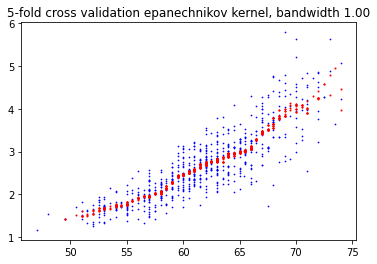

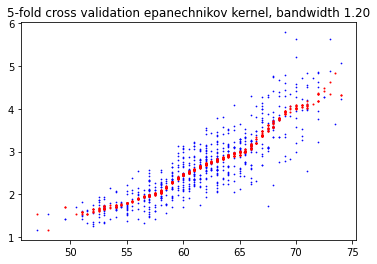

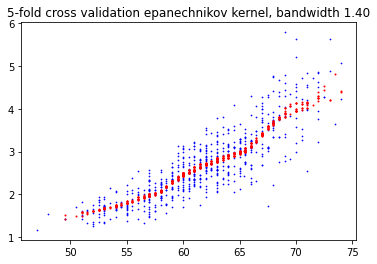

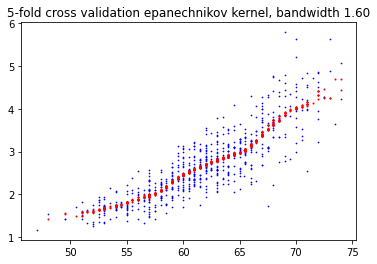

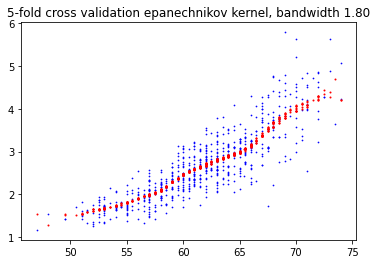

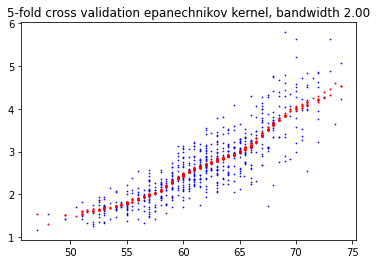

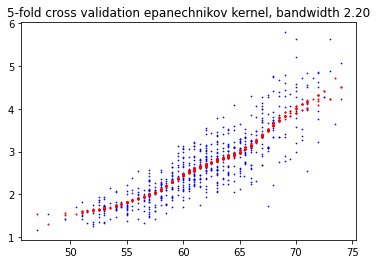

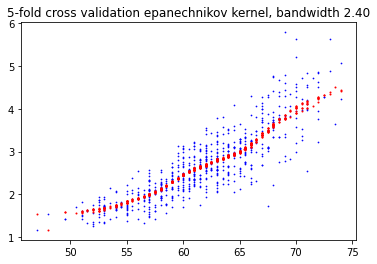

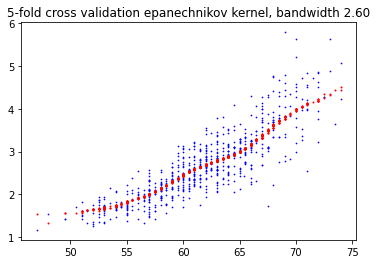

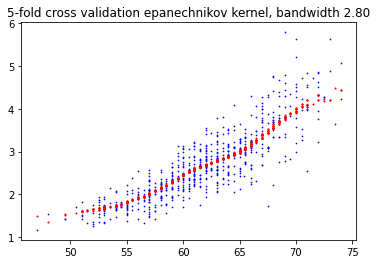

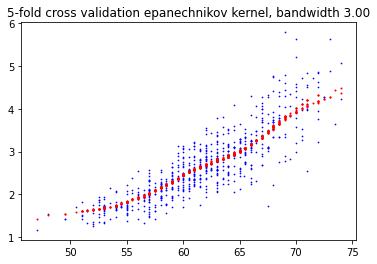

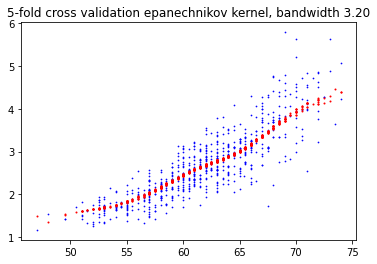

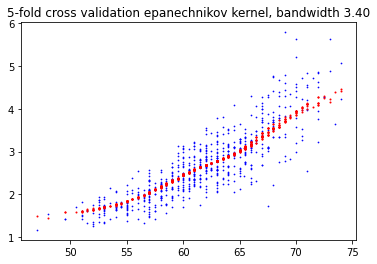

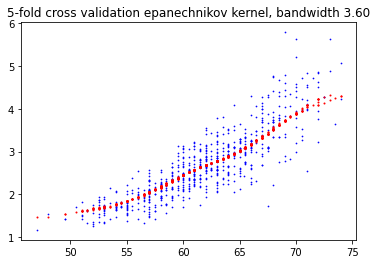

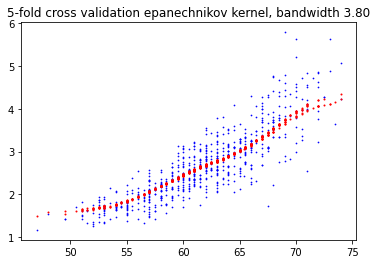

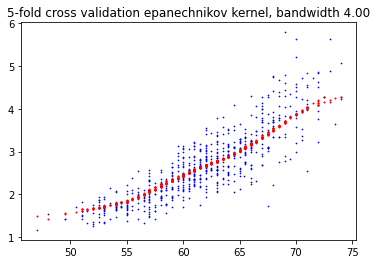

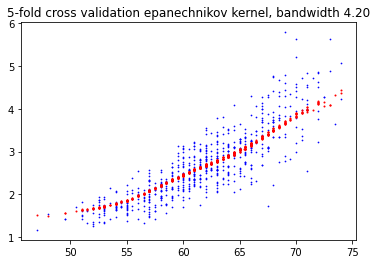

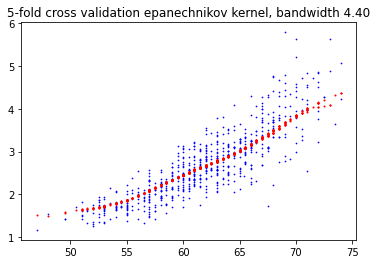

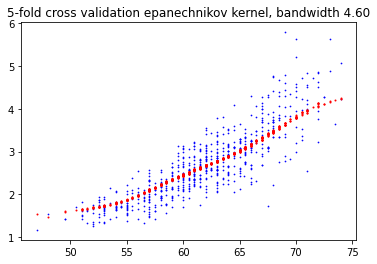

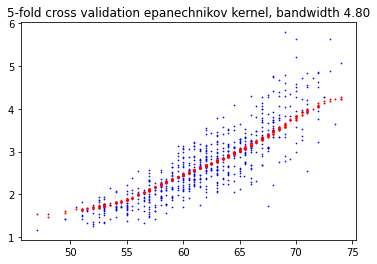

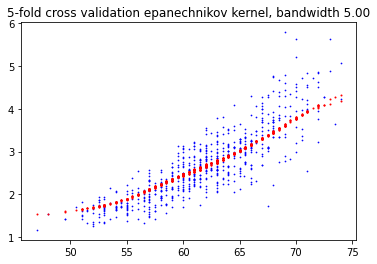

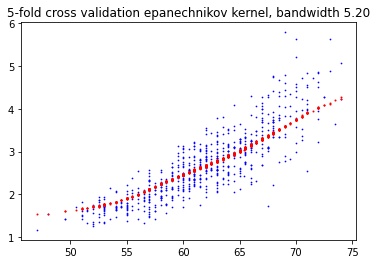

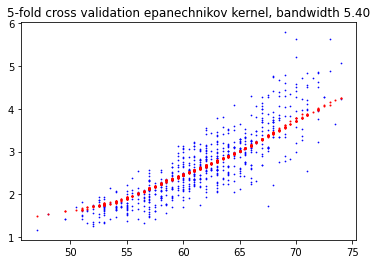

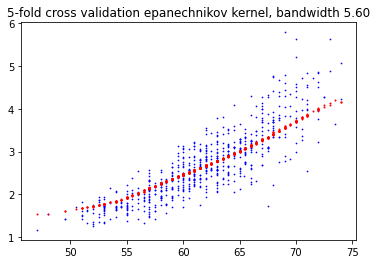

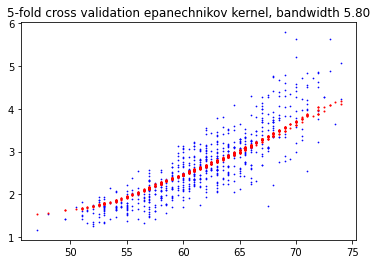

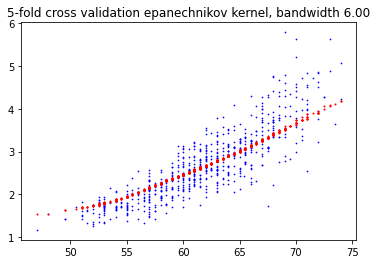

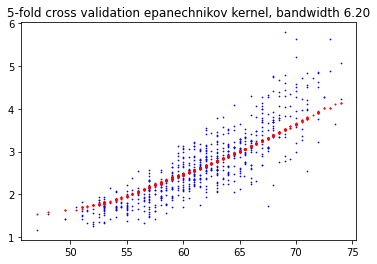

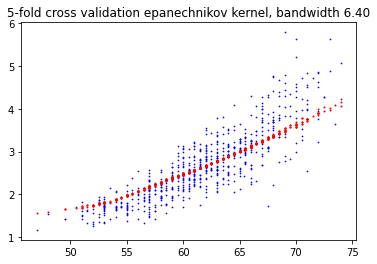

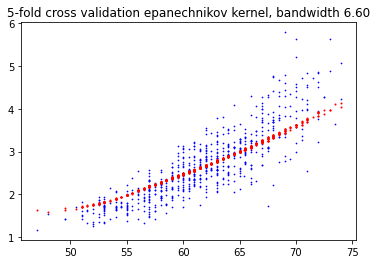

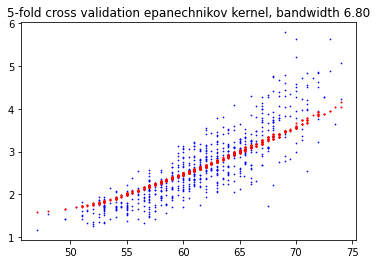

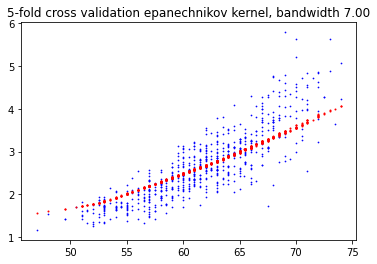

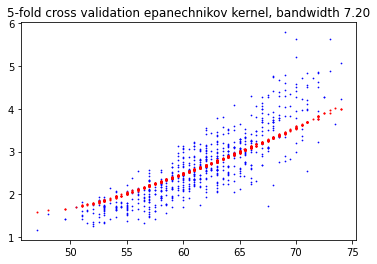

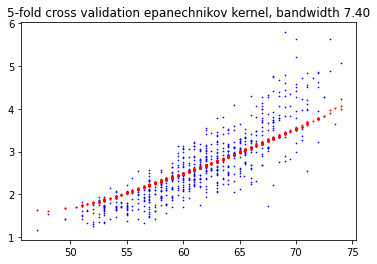

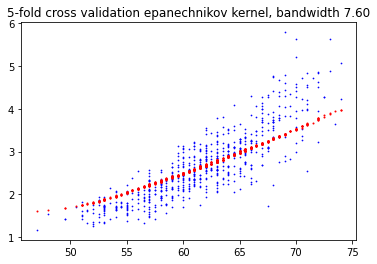

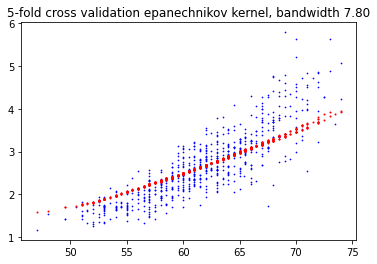

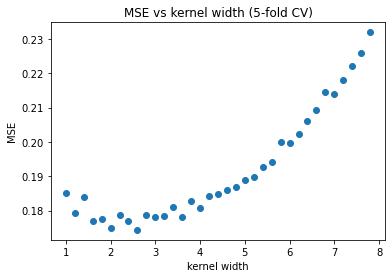

In [217]:
find_bandwidth_foldCV("epanechnikov", 5)

/var/folders/m6/g38qvsjd2fx7_7nfgc_1txxm0000gn/T/ipykernel_91041/3704602512.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


the minimum occurred at width: [[2.5]]


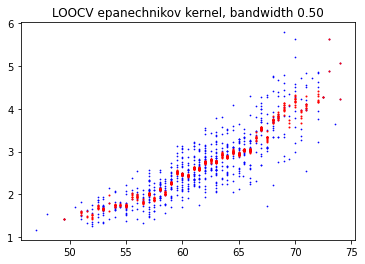

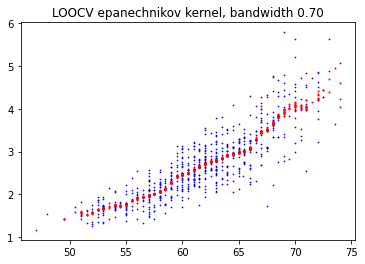

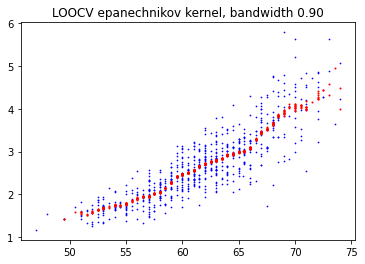

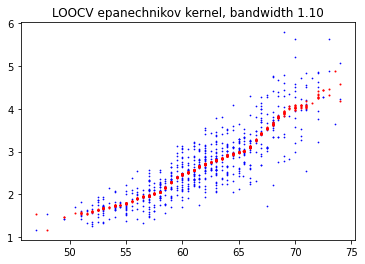

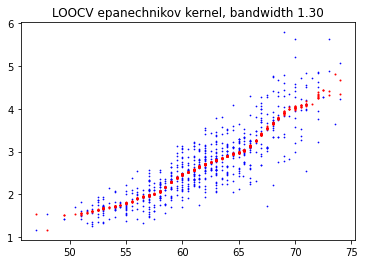

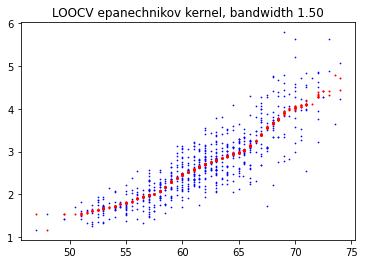

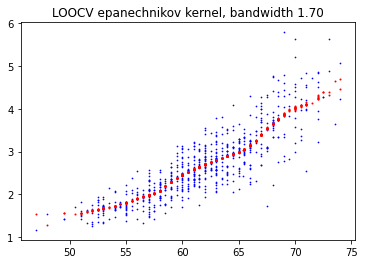

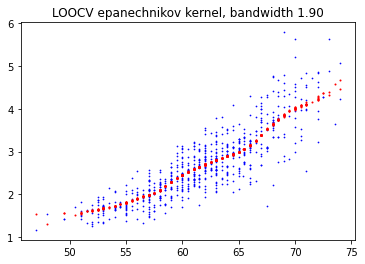

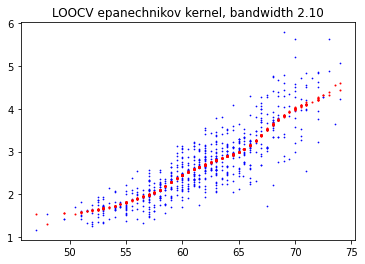

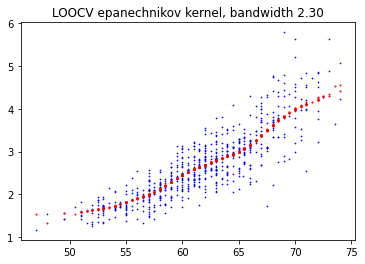

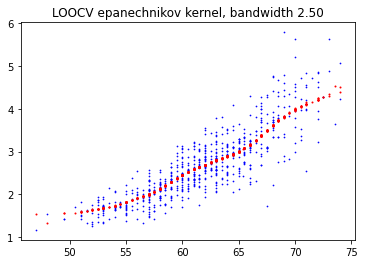

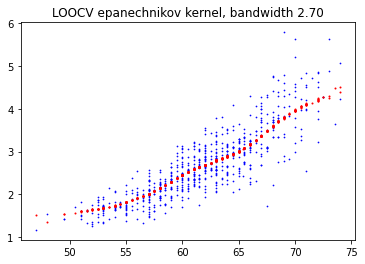

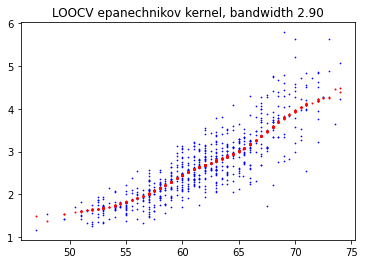

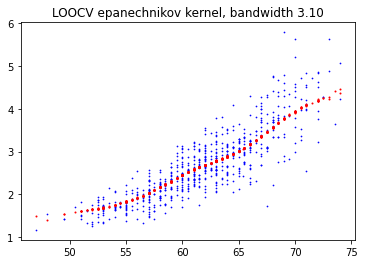

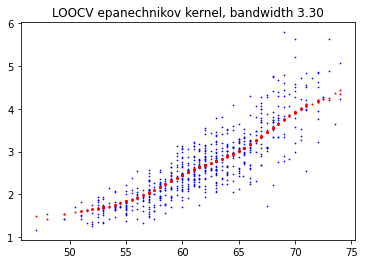

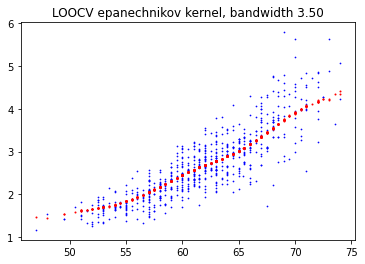

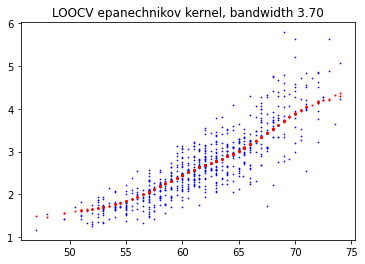

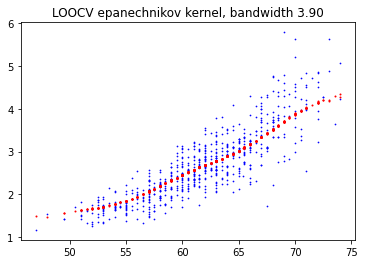

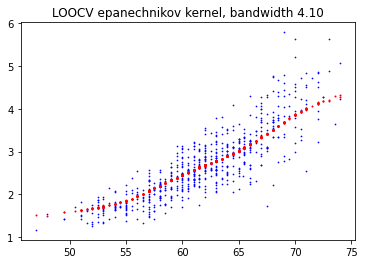

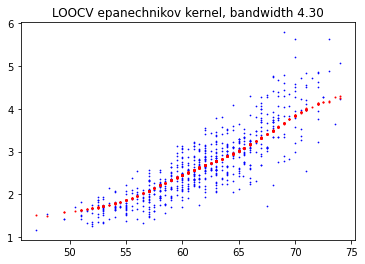

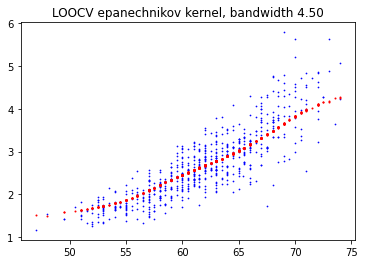

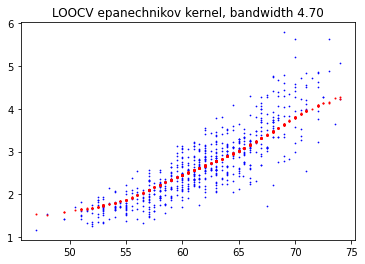

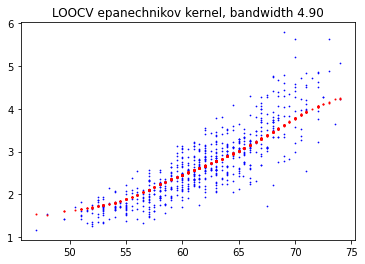

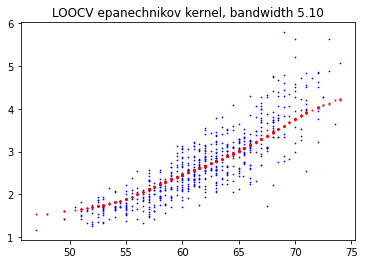

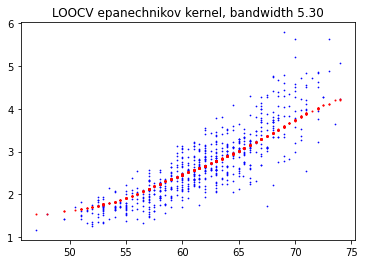

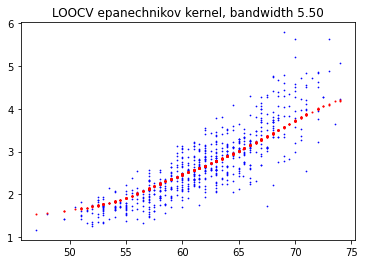

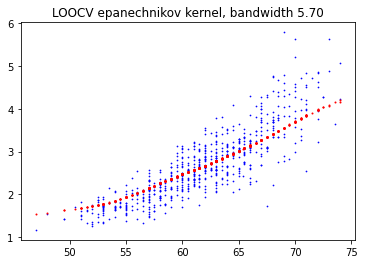

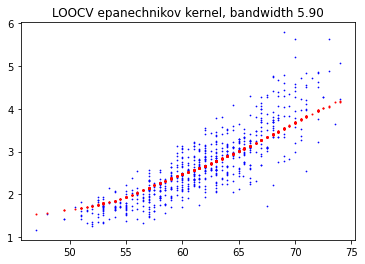

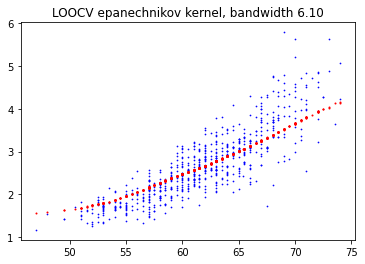

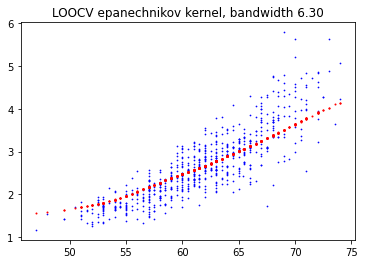

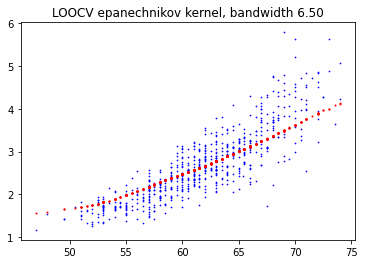

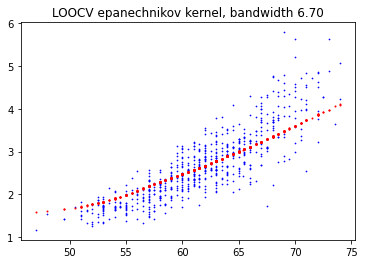

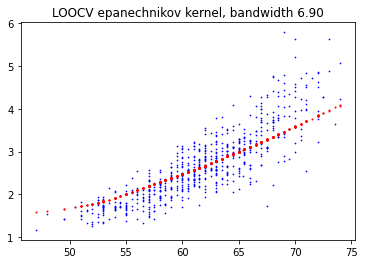

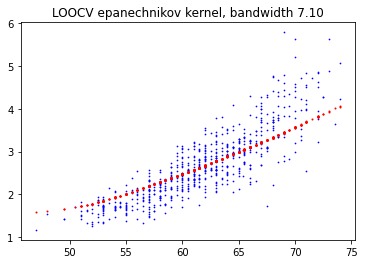

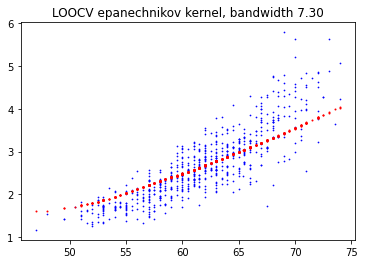

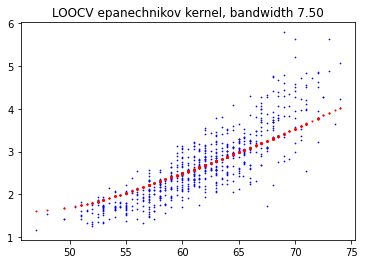

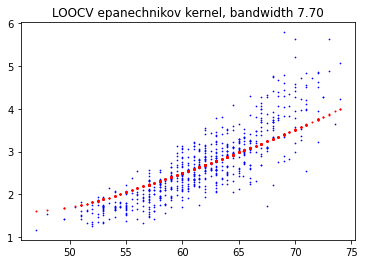

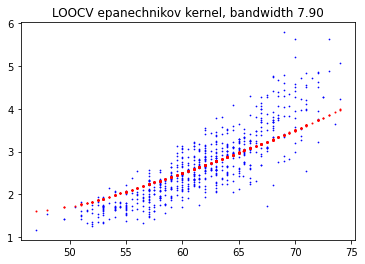

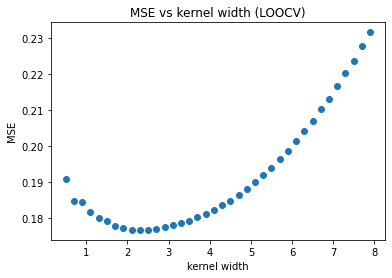

In [216]:
find_bandwidth_LOOCV("epanechnikov")

/var/folders/m6/g38qvsjd2fx7_7nfgc_1txxm0000gn/T/ipykernel_91041/2239252163.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


the minimum occurred at width: [[2.2]]


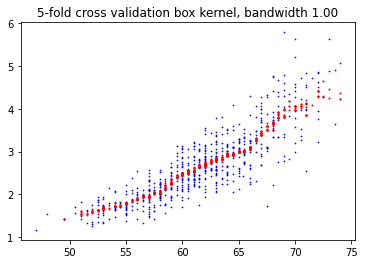

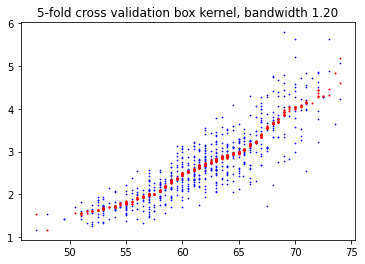

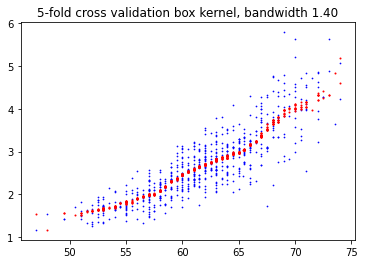

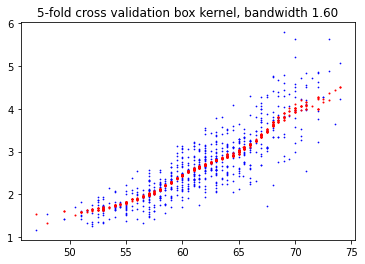

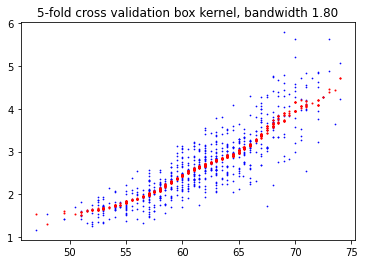

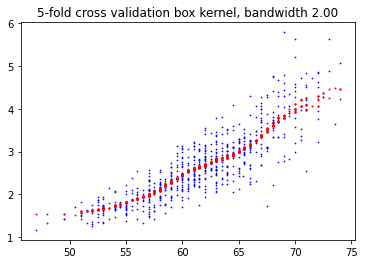

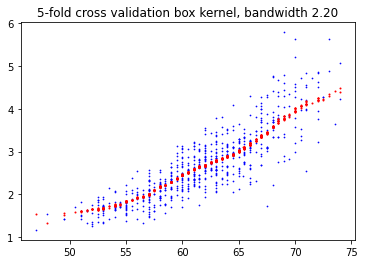

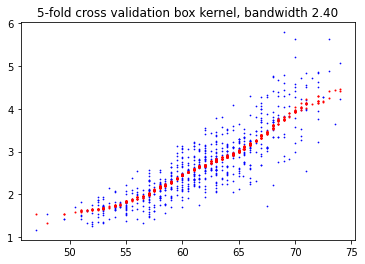

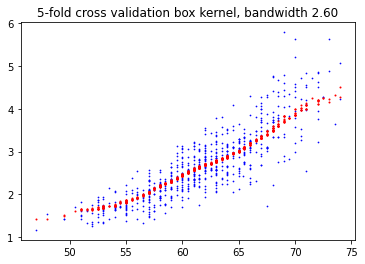

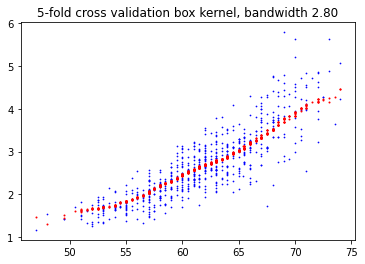

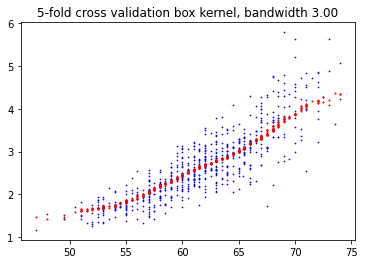

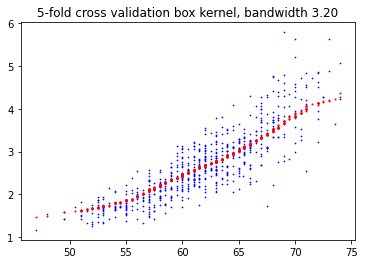

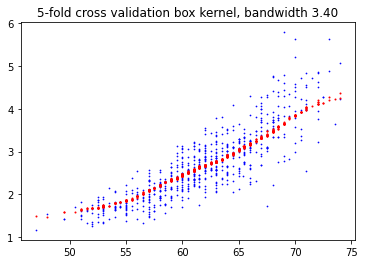

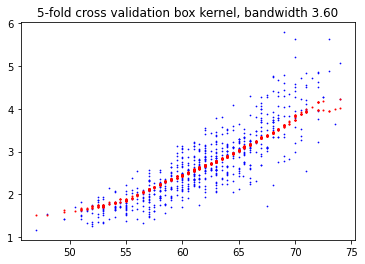

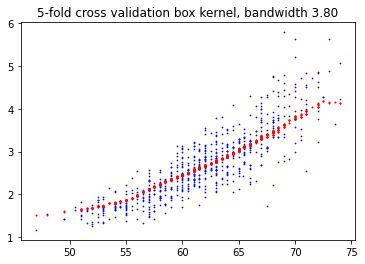

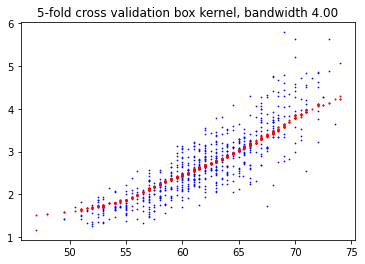

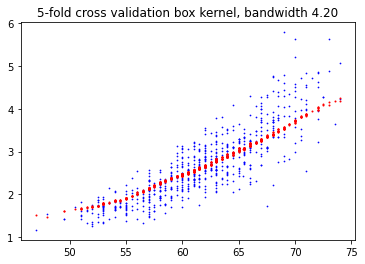

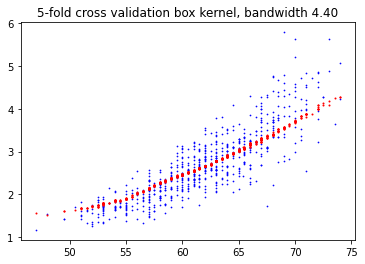

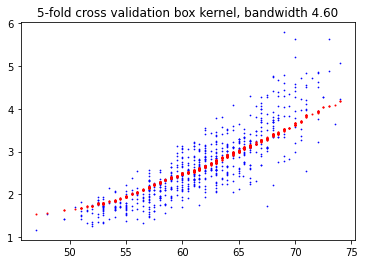

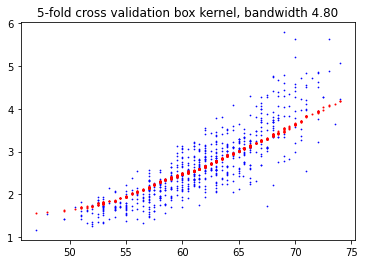

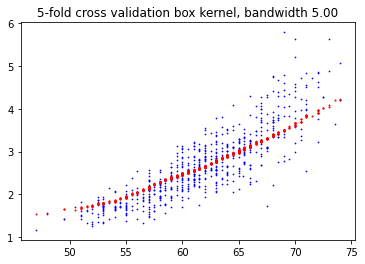

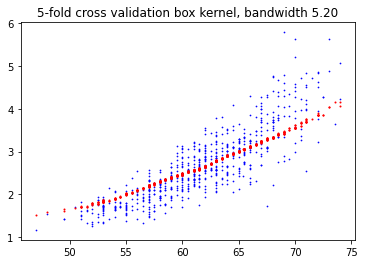

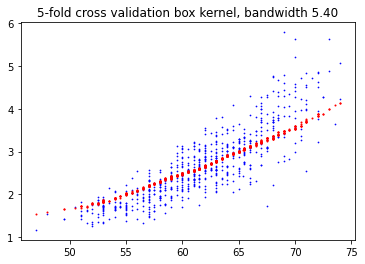

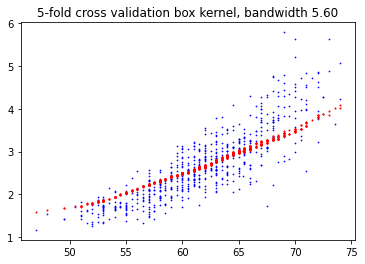

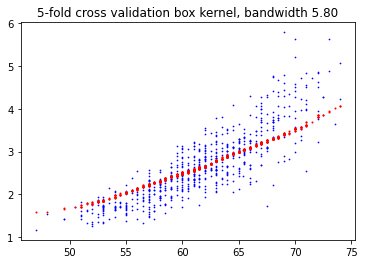

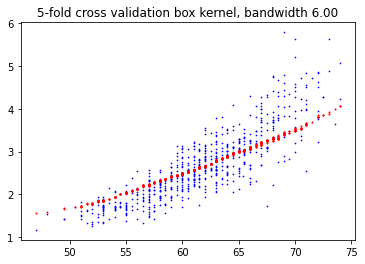

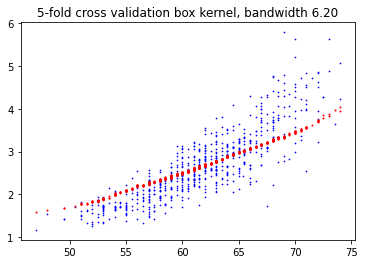

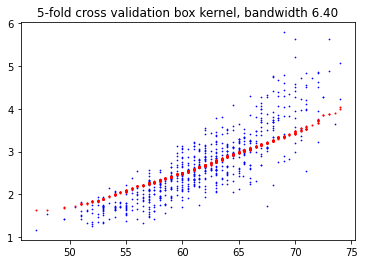

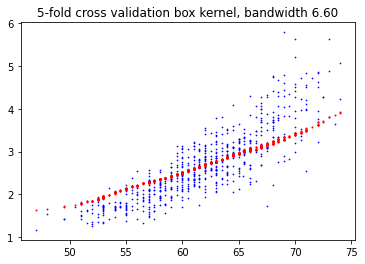

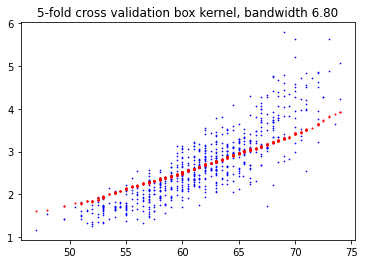

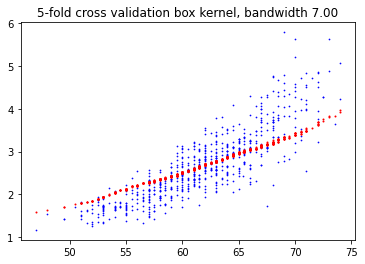

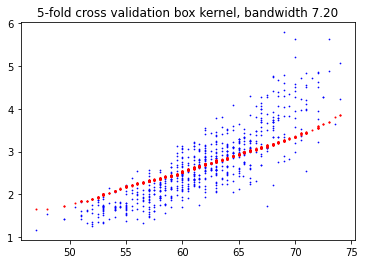

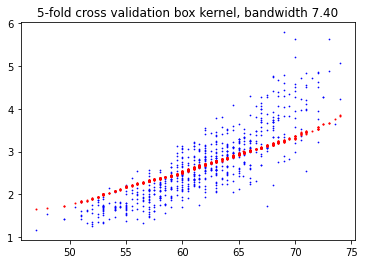

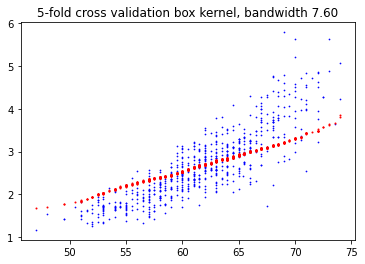

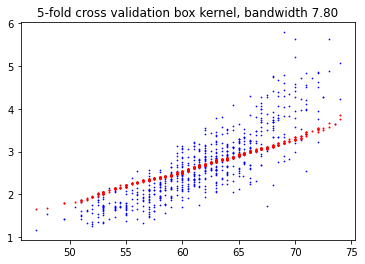

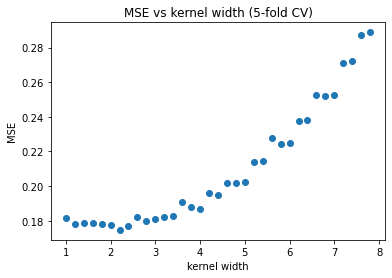

In [218]:
find_bandwidth_foldCV("box", 5)

/var/folders/m6/g38qvsjd2fx7_7nfgc_1txxm0000gn/T/ipykernel_91041/3704602512.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


the minimum occurred at width: [[1.7 1.9]]


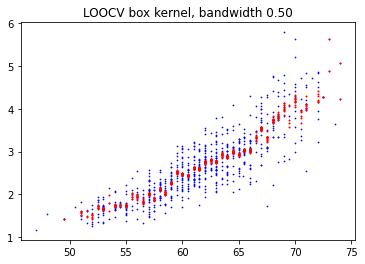

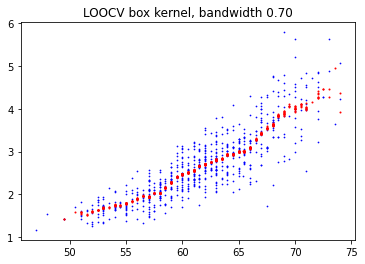

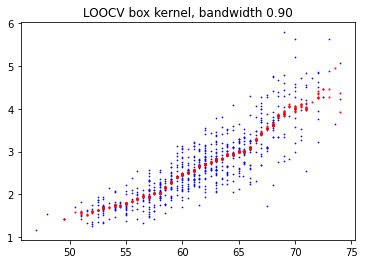

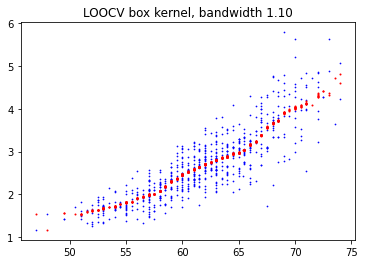

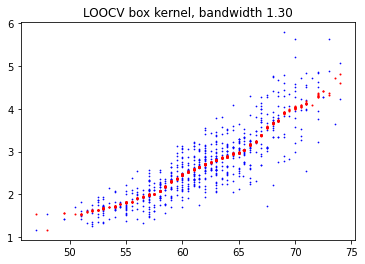

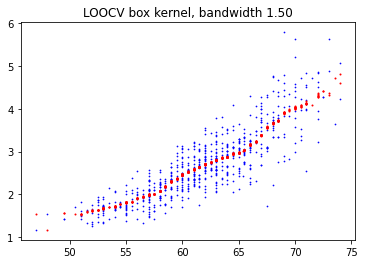

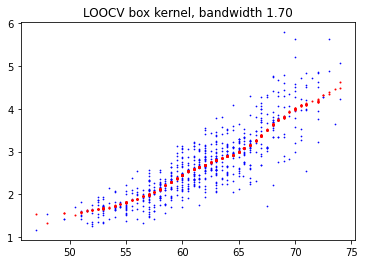

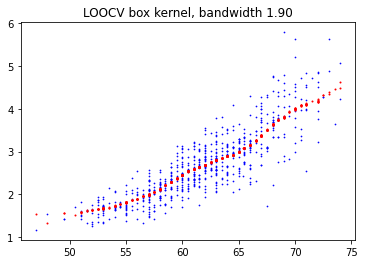

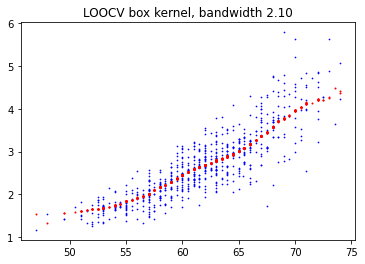

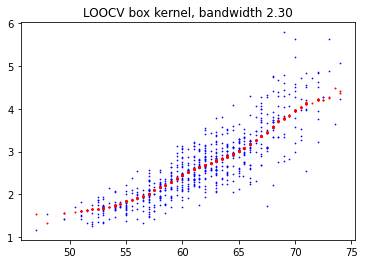

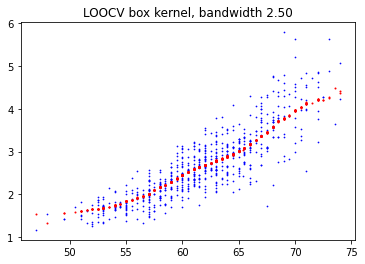

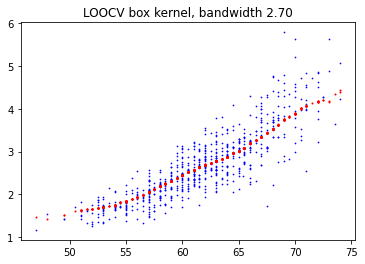

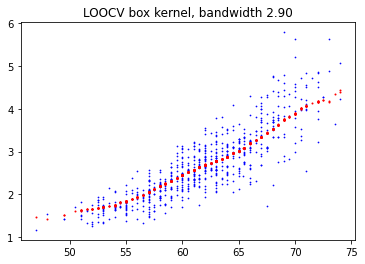

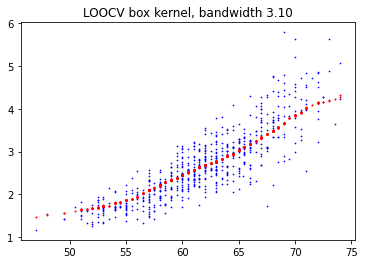

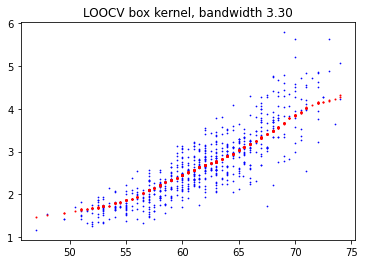

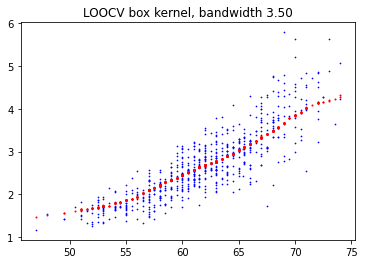

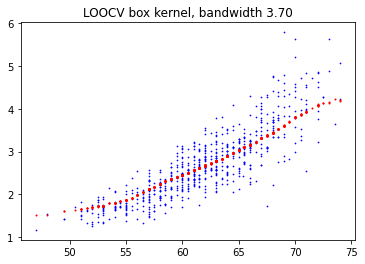

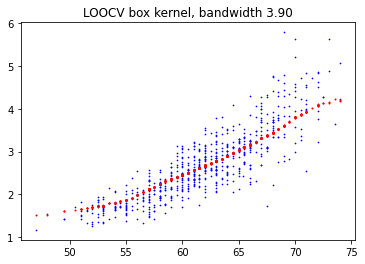

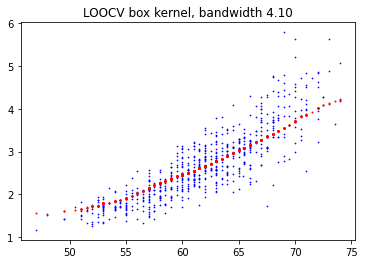

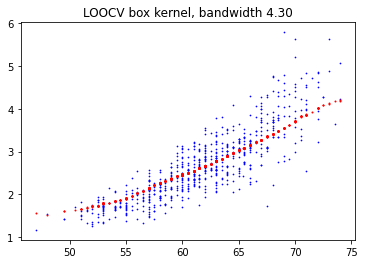

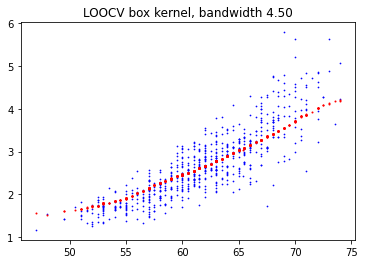

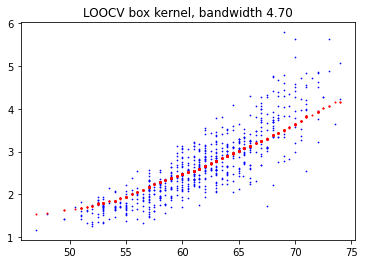

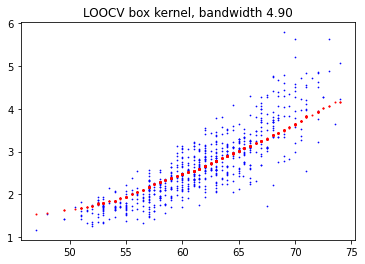

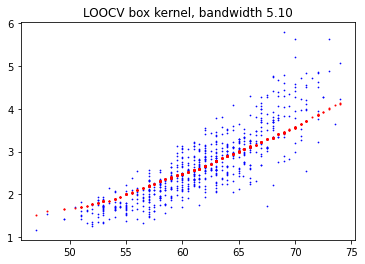

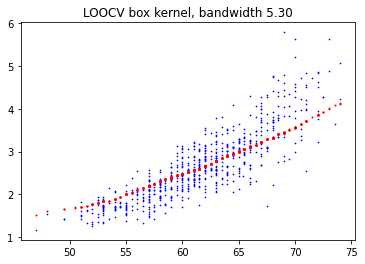

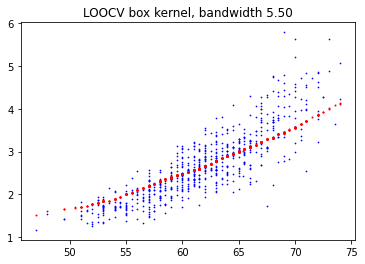

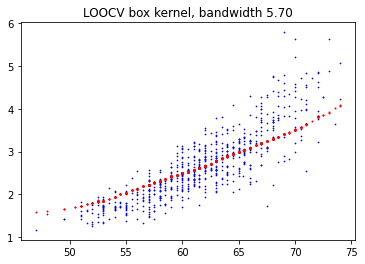

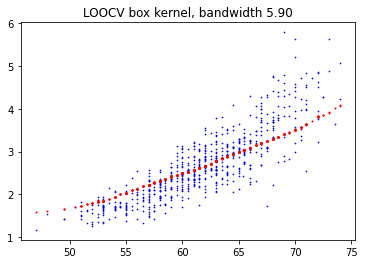

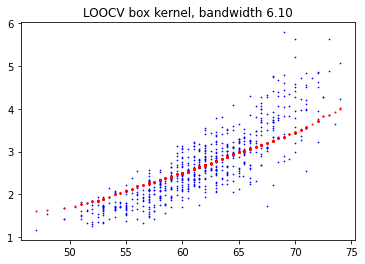

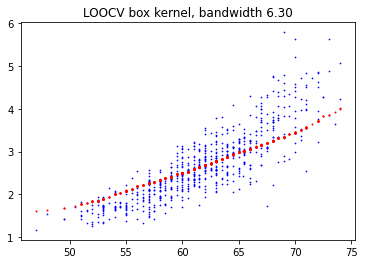

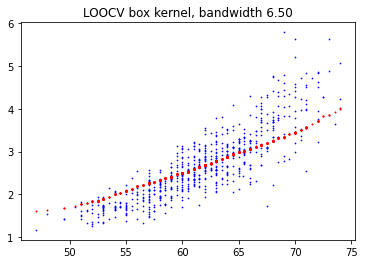

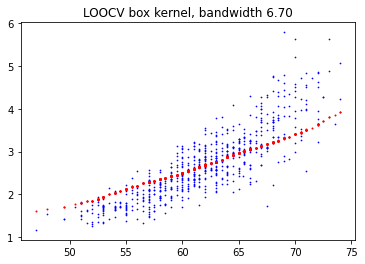

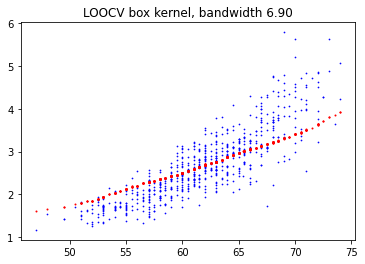

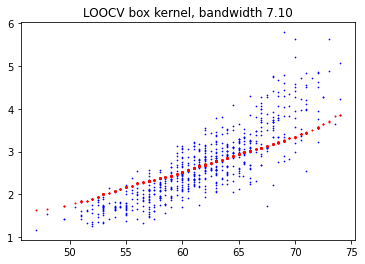

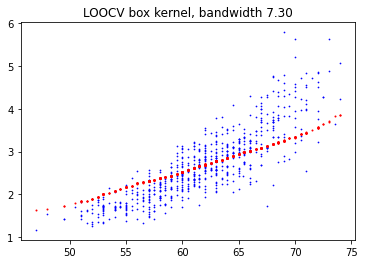

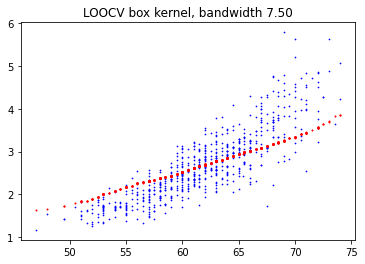

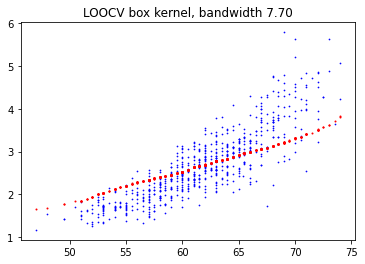

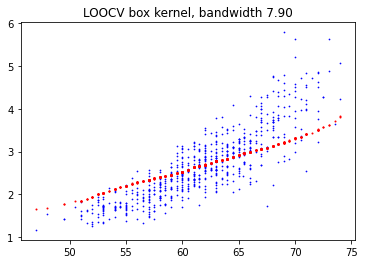

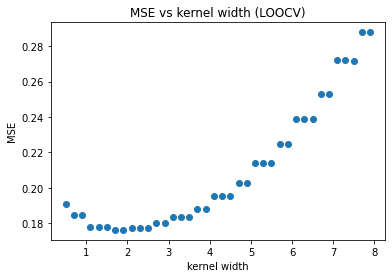

In [219]:
find_bandwidth_LOOCV("box")